In [1]:
library(car)      #influence plots and VIF
library(lmtest)   #heteroskedasticity tests

Loading required package: carData

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




fit ordinary least squares (OLS):
$y = X\beta + \varepsilon$, with $\hat{\beta} = \arg\min_{\beta} \lVert y - X\beta \rVert_2^2$

quantities you will see in diagnostics:
- fitted values: $\hat{y} = X\hat{\beta}$
- residuals: $e = y - \hat{y}$
- hat matrix: $H = X(X^\top X)^{-1}X^\top$, leverage $h_{ii} = H_{ii}$
- studentized residuals: residuals scaled by their estimated standard deviation, accounting for leverage

In [2]:
fit = lm(mpg ~ wt + hp + cyl, data = mtcars)
summary(fit)


Call:
lm(formula = mpg ~ wt + hp + cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9290 -1.5598 -0.5311  1.1850  5.8986 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 38.75179    1.78686  21.687  < 2e-16 ***
wt          -3.16697    0.74058  -4.276 0.000199 ***
hp          -0.01804    0.01188  -1.519 0.140015    
cyl         -0.94162    0.55092  -1.709 0.098480 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.512 on 28 degrees of freedom
Multiple R-squared:  0.8431,	Adjusted R-squared:  0.8263 
F-statistic: 50.17 on 3 and 28 DF,  p-value: 2.184e-11


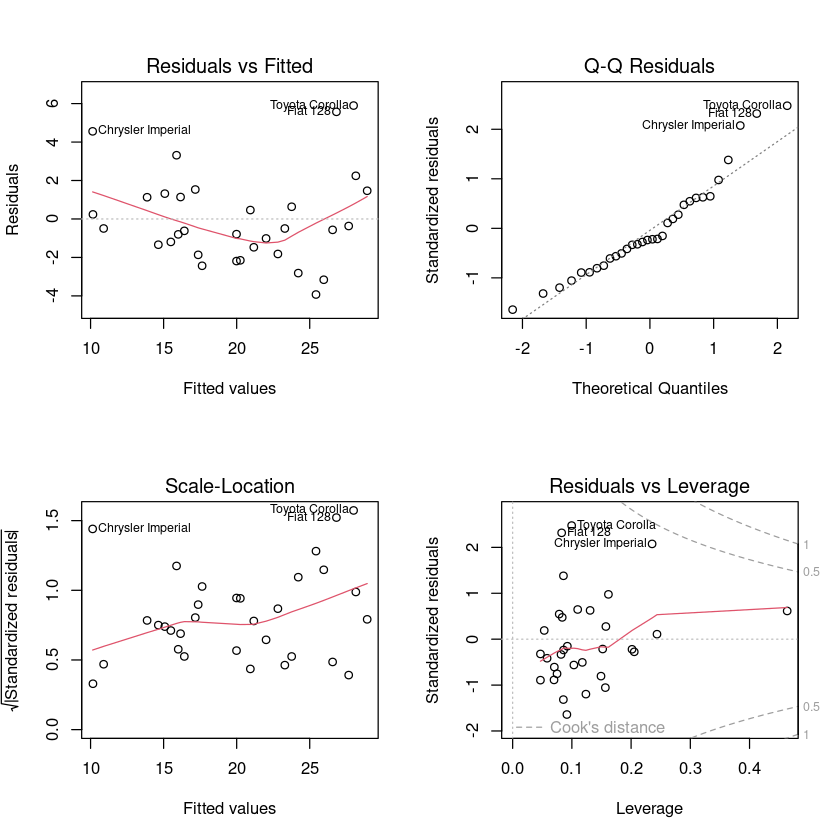

In [3]:
op = par(mfrow = c(2, 2))
plot(fit)
par(op)

1. Residuals vs Fitte
   What to look for: random scatter around zero.  
   Problems indicated: curvature suggests misspecification; funnel shape suggests heteroskedasticity

2. Normal Q-Q  
   What to look for: points close to the line.  
   Problems indicated: heavy tails or skew suggests residuals are not approximately normal.

3. Scale-Location  
   What to look for: horizontal band with roughly equal spread.  
   Problems indicated: upward trend suggests increasing variance with fitted value

4. Residuals vs Leverage with Cook's distance contours  
   What to look for: high leverage and large residuals.  
   Problems indicated: influential observations

# Cook's distance


Cook's distance measures how much the entire set of fitted values would change if a single observation were removed. A large value means the observation has strong influence on the fitted model.

A common form:
$D_i = \dfrac{e_i^2}{p\,\hat{\sigma}^2}\,\dfrac{h_{ii}}{(1 - h_{ii})^2}$

where $e_i$ is the residual, $h_{ii}$ is leverage, $p$ is the number of estimated parameters including the intercept, and $\hat{\sigma}^2$ is the residual variance.

Heuristics:
- Flag if $D_i > 4/n$
- Consider very influential if $D_i > 1$


In [4]:
n = nrow(mtcars)
p = length(coef(fit))
cd = cooks.distance(fit)

which(cd > 4/n)   # indices of potentially influential points

Chrysler Imperial    Toyota Corolla 
               17                20

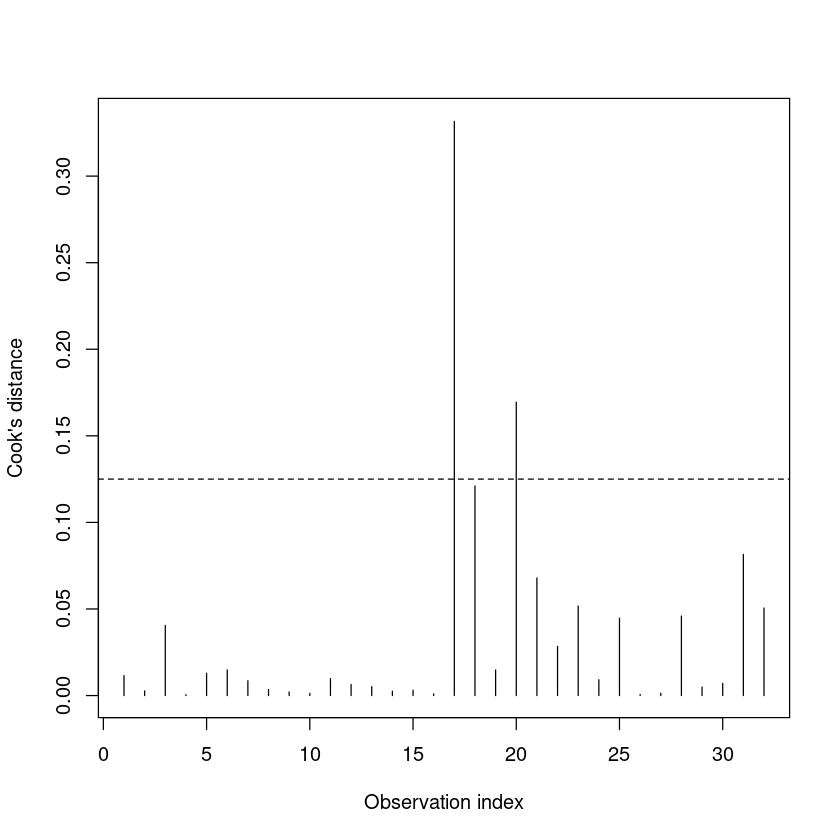

In [5]:
# visualize Cook's distances
plot(cd, type = "h", xlab = "Observation index", ylab = "Cook's distance")
abline(h = 4/n, lty = 2)
abline(h = 1, lty = 3)

In [9]:
mtcars[31,]

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Maserati Bora,15,8,301,335,3.54,3.57,14.6,0,1,5,8


,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
Lincoln Continental,0.1065775,0.24373270,0.0009486833
Chrysler Imperial,2.2153833,0.23547715,0.3316313326
Fiat 128,2.5303244,0.08274176,0.1210330843
Toyota Corolla,2.7498370,0.09961207,0.1694339333
Maserati Bora,0.6073374,0.46356582,0.0815260489


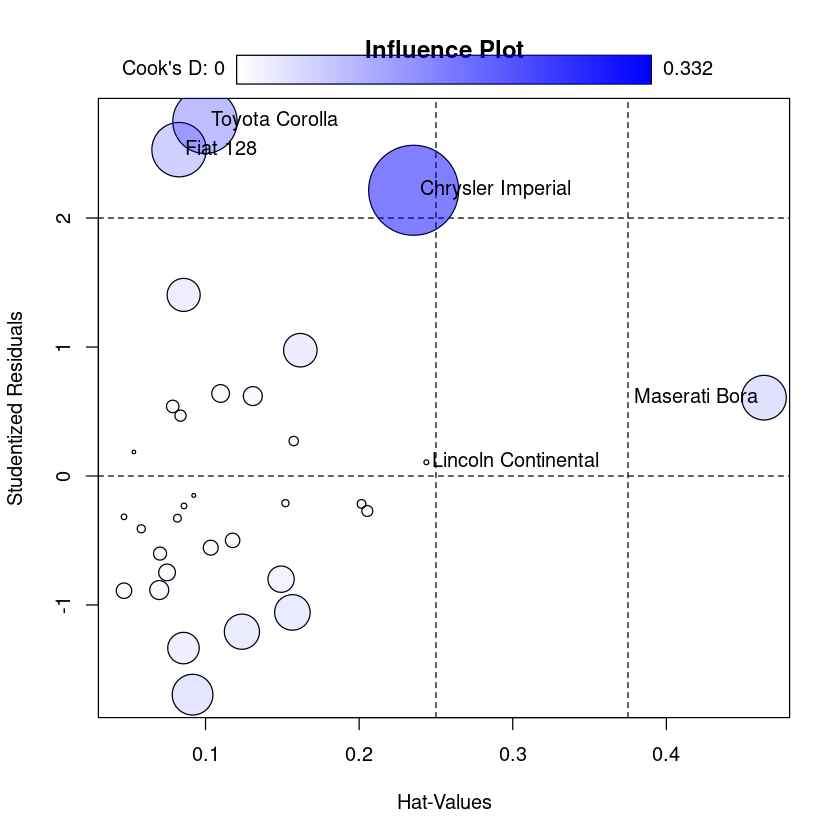

In [10]:
car::influencePlot(fit, main = "Influence Plot")  
#circle size is proportional to Cooks D


In [9]:
#Heteroskedasticity: A funnel in Residuals vs Fitted or Scale-Location 
#suggests non-constant variance

lmtest::bptest(fit)  # p < 0.05 suggests heteroskedasticity
#if present, consider a response transform (for example log)
#heteroskedasticity-robust standard errors, or explicit variance modeling


	studentized Breusch-Pagan test

data:  fit
BP = 2.9351, df = 3, p-value = 0.4017


In [10]:
#multicollinearity: not visible in the four plots but large 
#VIF values suggest unstable coefficients

car::vif(fit)

wt       hp      cyl 
2.580486 3.258481 4.757456

In [11]:
#outliers and influence
#high absolute studentized residuals indicate outliers in y
#large leverage with large residuals indicates influence
#Cook's distance combines both
rstud = rstudent(fit)
lev = hatvalues(fit)
influence_df = data.frame(obs = rownames(mtcars),
                          rstudent = rstud,
                          leverage = lev,
                          cooksD = cd)
head(influence_df[order(-influence_df$cooksD), ], 10)

,obs,rstudent,leverage,cooksD
,<chr>,<dbl>,<dbl>,<dbl>
Chrysler Imperial,Chrysler Imperial,2.2153833,0.23547715,0.33163133
Toyota Corolla,Toyota Corolla,2.7498370,0.09961207,0.16943393
Fiat 128,Fiat 128,2.5303244,0.08274176,0.12103308
Maserati Bora,Maserati Bora,0.6073374,0.46356582,0.08152605
Toyota Corona,Toyota Corona,-1.6953756,0.09155927,0.06787939
AMC Javelin,AMC Javelin,-1.0577210,0.15654328,0.05169108
Volvo 142E,Volvo 142E,-1.2070326,0.12368549,0.05058326
Lotus Europa,Lotus Europa,0.9752688,0.16171087,0.04595073
Pontiac Firebird,Pontiac Firebird,1.4040889,0.08575683,0.04468109


# reporting cook's distance

- define it: cook's distance quantifies how much fitted values would change if an observation were removed
- thresholds: report how many and which points exceed 4/n, and note any above 1
- sensitivity: refit without flagged points and compare key coefficients and fit summaries. Explain any decisions to keep or remove observations

# takeaways

- Use the four base plots to check nonlinearity, non-normality, heteroskedasticity, and influence
- cook's distance combines residual size and leverage to flag observations that can change your conclusions
- diagnose, explain, then fix: transform variables, add terms, use robust methods, or re-specify the model. document sensitivity

# template ( boiler plate )

```r
# fit
fit = lm(response ~ predictor1 + predictor2, data = your_data)

# plots
op = par(mfrow = c(2, 2)); plot(fit); par(op)

# heteroskedasticity
lmtest::bptest(fit)

# multicollinearity
car::vif(fit)

# influence summary
n = nrow(model.frame(fit))
cd = cooks.distance(fit)
flag = which(cd > 4/n)
print(flag)

plot(cd, type = "h", xlab = "observation index", ylab = "cooks distance")
abline(h = 4/n, lty = 2)

# sensitivity check: remove most influential and compare
idx = which.max(cd)
fit_sans = update(fit, subset = -idx)
summary(fit)
summary(fit_sans)
```




	studentized Breusch-Pagan test

data:  fit
BP = 2.9351, df = 3, p-value = 0.4017


wt       hp      cyl 
2.580486 3.258481 4.757456

Chrysler Imperial    Toyota Corolla 
               17                20 


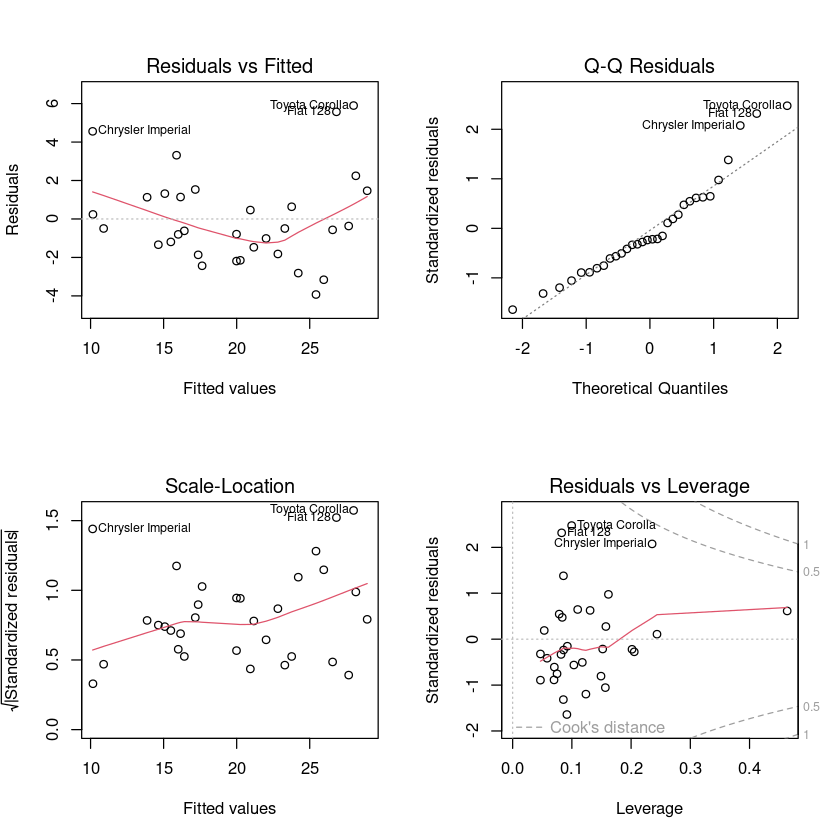


Call:
lm(formula = mpg ~ wt + hp + cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9290 -1.5598 -0.5311  1.1850  5.8986 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 38.75179    1.78686  21.687  < 2e-16 ***
wt          -3.16697    0.74058  -4.276 0.000199 ***
hp          -0.01804    0.01188  -1.519 0.140015    
cyl         -0.94162    0.55092  -1.709 0.098480 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.512 on 28 degrees of freedom
Multiple R-squared:  0.8431,	Adjusted R-squared:  0.8263 
F-statistic: 50.17 on 3 and 28 DF,  p-value: 2.184e-11



Call:
lm(formula = mpg ~ wt + hp + cyl, data = mtcars, subset = -idx)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7891 -1.6612 -0.6198  1.3509  5.4996 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 39.47383    1.70530  23.148  < 2e-16 ***
wt          -3.86255    0.76149  -5.072 2.51e-05 ***
hp          -0.02118    0.01122  -1.889   0.0697 .  
cyl         -0.65220    0.53236  -1.225   0.2311    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.353 on 27 degrees of freedom
Multiple R-squared:  0.8636,	Adjusted R-squared:  0.8485 
F-statistic:    57 on 3 and 27 DF,  p-value: 8.28e-12


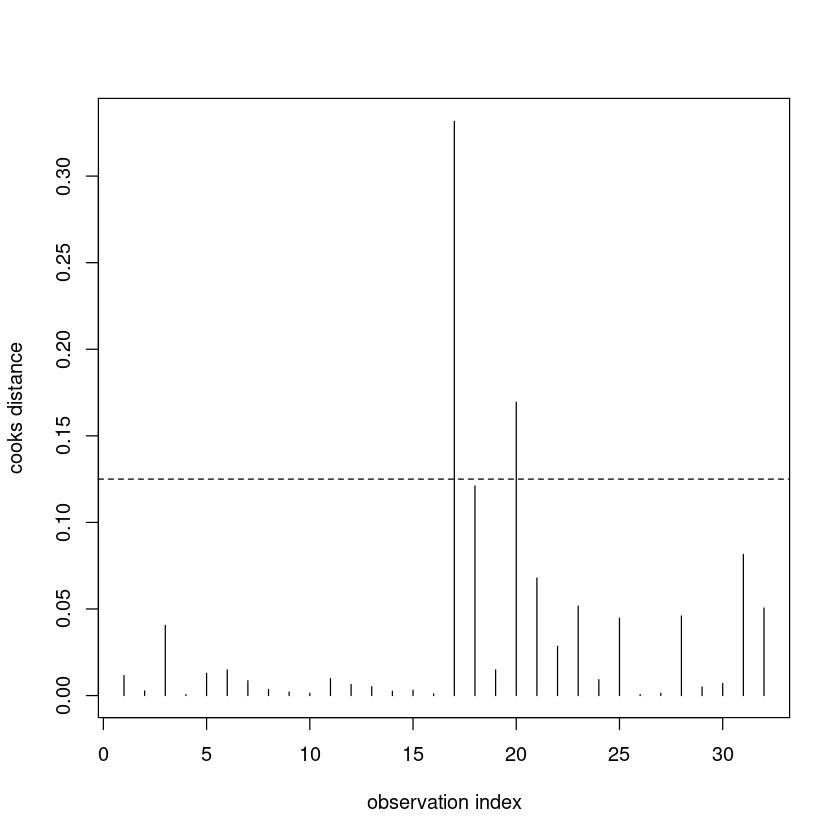

In [15]:
fit = lm(mpg ~ wt + hp + cyl, data = mtcars)

# plots
op = par(mfrow = c(2, 2)); plot(fit); par(op)

# heteroskedasticity
lmtest::bptest(fit)

# multicollinearity
car::vif(fit)

# influence summary
n = nrow(model.frame(fit))
cd = cooks.distance(fit)
flag = which(cd > 4/n)
print(flag)

plot(cd, type = "h", xlab = "observation index", ylab = "cooks distance")
abline(h = 4/n, lty = 2)

# sensitivity check: remove most influential and compare
idx = which.max(cd)
fit_sans = update(fit, subset = -idx)
summary(fit)
summary(fit_sans)